In [1]:
# ============================================================================
# CELL 0 : SETUP - PHASE 3B (REVISED CQL)
# ============================================================================

import os
import sys
from pathlib import Path

os.chdir('/workspaces/energy-rl-project')
sys.path.insert(0, '/workspaces/energy-rl-project/src')

os.environ['EPLUS_PATH'] = '/usr/local/EnergyPlus-24-2-0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from src.config import DATA_OFFLINE_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.algorithms.cql import CQL  # ⭐ Version avec Double Q-Learning
from src.algorithms.offline_replay_buffer import OfflineReplayBuffer, load_statistics

print("✅ Setup Phase 3B (REVISED) terminé")
print(f"   Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

# Vérifier si le dataset existe
dataset_path = DATA_OFFLINE_DIR / 'offline_dataset.pkl'
if not dataset_path.exists():
    print(f"❌ Dataset not found: {dataset_path}")
    print("   Please run Phase 3A first!")
    sys.exit(1)
else:
    print(f"✅ Dataset found: {dataset_path}")

Couldn't import dot_parser, loading of dot files will not be possible.
[CONFIG] Sinergym logs directory: /workspaces/energy-rl-project/data/raw
✅ Setup Phase 3B (REVISED) terminé
   Device: CPU
✅ Dataset found: /workspaces/energy-rl-project/data/offline_dataset/offline_dataset.pkl


In [2]:
# ============================================================================
# CELL 1 : CHARGER LE DATASET NORMALISÉ
# ============================================================================

print("\n" + "=" * 80)
print("📂 CHARGEMENT DU DATASET NORMALISÉ")
print("=" * 80)

# Charger buffer
buffer = OfflineReplayBuffer()
buffer.load(str(DATA_OFFLINE_DIR / 'offline_dataset.pkl'))

# Charger stats
stats = load_statistics(str(DATA_OFFLINE_DIR / 'dataset_stats.json'))
norm_stats = load_statistics(str(DATA_OFFLINE_DIR / 'normalization_stats.json'))

print(f"\n📊 Dataset Statistics:")
print(f"   Transitions: {len(buffer)}")
print(f"   Obs shape: {stats['obs_shape']}")
print(f"   Action shape: {stats['action_shape']}")
print(f"   Reward mean: {stats['reward_mean']:.4f}")
print(f"   Reward std: {stats['reward_std']:.4f}")
print(f"   Reward min: {stats['reward_min']:.4f}")
print(f"   Reward max: {stats['reward_max']:.4f}")

# Déterminer les dimensions
obs_sample, action_sample, _, _, _ = buffer.sample(1)
state_dim = obs_sample.shape[1]
action_dim = action_sample.shape[1]

print(f"\n🔧 Agent dimensions:")
print(f"   State dim: {state_dim}")
print(f"   Action dim: {action_dim}")

# Sauvegarder les stats de normalisation pour utilisation ultérieure
print(f"\n📈 Normalization stats loaded:")
print(f"   Obs mean: {norm_stats['obs_mean'][:3]}...")
print(f"   Obs std: {norm_stats['obs_std'][:3]}...")


📂 CHARGEMENT DU DATASET NORMALISÉ


✅ Buffer loaded from /workspaces/energy-rl-project/data/offline_dataset/offline_dataset.pkl (50000 transitions)
✅ Statistics loaded from /workspaces/energy-rl-project/data/offline_dataset/dataset_stats.json
✅ Statistics loaded from /workspaces/energy-rl-project/data/offline_dataset/normalization_stats.json

📊 Dataset Statistics:
   Transitions: 50000
   Obs shape: [18]
   Action shape: [3]
   Reward mean: -2.2603
   Reward std: 3.0490
   Reward min: -10.0000
   Reward max: -0.0028

🔧 Agent dimensions:
   State dim: 18
   Action dim: 3

📈 Normalization stats loaded:
   Obs mean: [1.0, 1.848, 10.4]...
   Obs std: [1.0, 0.7699974025929394, 6.699253689778056]...


In [3]:
# ============================================================================
# CELL 2 : CRÉER ET ENTRAÎNER CQL (500 EPOCHS - AUGMENTÉ de 100)
# ============================================================================

print("\n" + "=" * 80)
print("🎓 CQL OFFLINE TRAINING (IMPROVED DOUBLE Q-LEARNING)")
print("=" * 80)

# ⭐ CONFIGURATION AMÉLIORÉE
NUM_EPOCHS = 500  # ⬆️ AUGMENTÉ de 100 à 500
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
UPDATES_PER_EPOCH = 10  # ⭐ Plusieurs updates par epoch

# Créer agent
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🔧 Creating CQL agent (Double Q-Learning)...")
cql_agent = CQL(
    state_dim=state_dim,
    action_dim=action_dim,
    hidden_dim=256,
    learning_rate=LEARNING_RATE,
    gamma=0.99,
    cql_weight=10.0,    # ⭐ AUGMENTÉ de 1.0 à 10.0
    cql_temp=0.3,       # ⭐ DIMINUÉ de 1.0 à 0.3
    num_random_actions=10,
    device=device
)

print(f"✅ CQL agent created (device: {device})")
print(f"   - Double Q-Learning: Q1 + Q2")
print(f"   - CQL Weight: 10.0 (strong offline penalty)")
print(f"   - CQL Temp: 0.3 (focused penalty)")
print(f"   - Gradient clipping: 1.0 (stable training)")

# Logs
log_file = RESULTS_LOGS_DIR / 'phase_3b_offline_training.log'
with open(log_file, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("Phase 3B : CQL Offline Training (IMPROVED)\n")
    f.write(f"Start: {datetime.now()}\n")
    f.write(f"CQL Weight: 10.0, CQL Temp: 0.3\n")
    f.write(f"Double Q-Learning: Q1 + Q2\n")
    f.write("=" * 80 + "\n\n")

# Training loop
losses = {'td_loss': [], 'cql_penalty': [], 'total_loss': []}

print(f"\n🎯 Training for {NUM_EPOCHS} epochs...")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Updates per epoch: {UPDATES_PER_EPOCH}")
print(f"   Dataset size: {len(buffer)} transitions\n")

for epoch in range(NUM_EPOCHS):
    epoch_losses = {'td_loss': [], 'cql_penalty': [], 'total_loss': []}
    
    # ⭐ PLUSIEURS UPDATES PAR EPOCH
    for update_idx in range(UPDATES_PER_EPOCH):
        loss_dict = cql_agent.train_step(buffer, batch_size=BATCH_SIZE)
        
        if loss_dict:
            for key, val in loss_dict.items():
                epoch_losses[key].append(val)
    
    # Moyenne sur l'epoch
    for key in losses.keys():
        if epoch_losses[key]:
            avg_loss = np.mean(epoch_losses[key])
            losses[key].append(avg_loss)
    
    # Print tous les 50 epochs (au lieu de 10)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1:3d}/{NUM_EPOCHS}")
        if losses['td_loss']:
            print(f"   TD Loss:      {losses['td_loss'][-1]:10.6f}")
        if losses['cql_penalty']:
            print(f"   CQL Penalty:  {losses['cql_penalty'][-1]:10.6f}")
        if losses['total_loss']:
            print(f"   Total Loss:   {losses['total_loss'][-1]:10.6f}")
        print()
    
    # Log all epochs
    with open(log_file, 'a') as f:
        f.write(f"Epoch {epoch + 1}\n")
        if losses['td_loss']:
            f.write(f"   TD Loss: {losses['td_loss'][-1]:.6f}\n")
        if losses['cql_penalty']:
            f.write(f"   CQL Penalty: {losses['cql_penalty'][-1]:.6f}\n")
        if losses['total_loss']:
            f.write(f"   Total Loss: {losses['total_loss'][-1]:.6f}\n")

print("=" * 80)
print("✅ CQL TRAINING TERMINÉ")
print("=" * 80)

with open(log_file, 'a') as f:
    f.write(f"\nEnd: {datetime.now()}\n")


🎓 CQL OFFLINE TRAINING (IMPROVED DOUBLE Q-LEARNING)

🔧 Creating CQL agent (Double Q-Learning)...
✅ CQL agent created (device: cpu)
   - Double Q-Learning: Q1 + Q2
   - CQL Weight: 10.0 (strong offline penalty)
   - CQL Temp: 0.3 (focused penalty)
   - Gradient clipping: 1.0 (stable training)

🎯 Training for 500 epochs...
   Batch size: 64
   Updates per epoch: 10
   Dataset size: 50000 transitions

Epoch  50/500
   TD Loss:       95.999202
   CQL Penalty:  -58.714906
   Total Loss:   -491.149860

Epoch 100/500
   TD Loss:      107.842807
   CQL Penalty:  -120.521558
   Total Loss:   -1097.372791

Epoch 150/500
   TD Loss:      121.726546
   CQL Penalty:  -187.800237
   Total Loss:   -1756.275830

Epoch 200/500
   TD Loss:      128.170287
   CQL Penalty:  -256.762700
   Total Loss:   -2439.456714

Epoch 250/500
   TD Loss:      132.833572
   CQL Penalty:  -328.359500
   Total Loss:   -3150.761450

Epoch 300/500
   TD Loss:      134.221497
   CQL Penalty:  -399.181027
   Total Loss:   -


💾 SAUVEGARDE ET VISUALISATION

📝 Sauvegarde CQL (Double Q-Learning)...
✅ Saved: /workspaces/energy-rl-project/results/checkpoints/cql_agent.pt

✅ Figure saved: phase_3b_cql_training.png


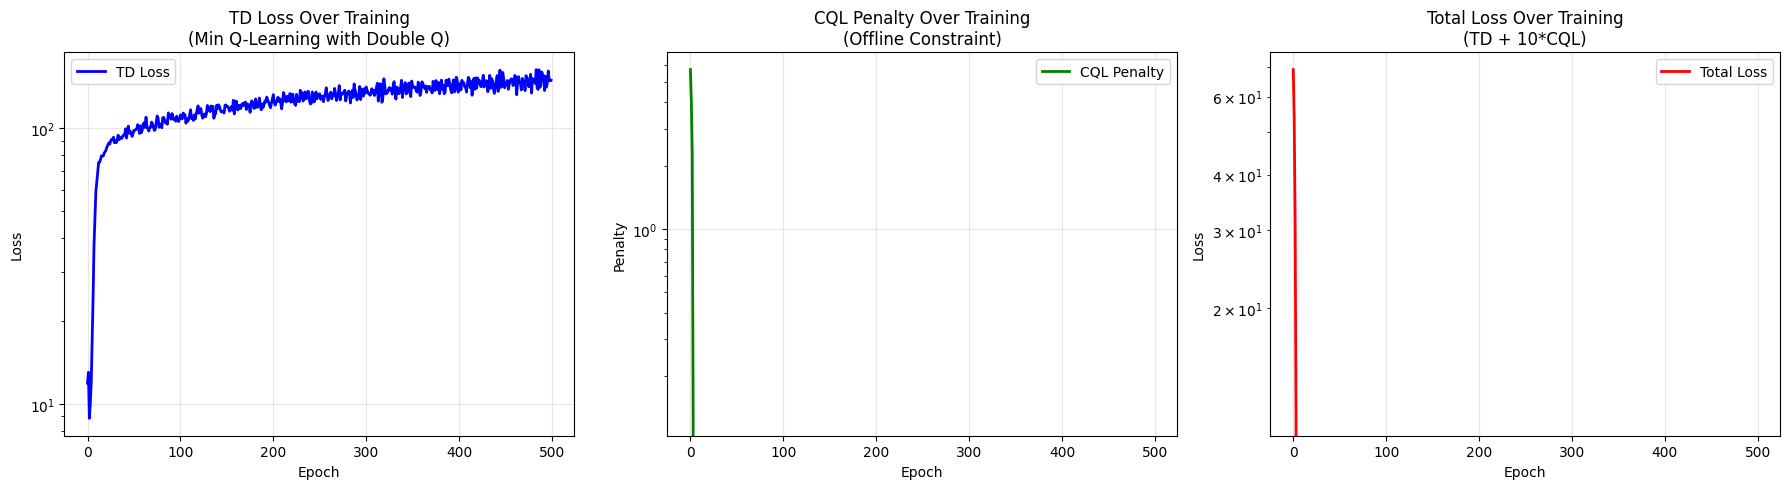


✅ PHASE 3B TERMINÉE
   CQL agent saved: /workspaces/energy-rl-project/results/checkpoints/cql_agent.pt
   Training epochs: 500 (500 avec 10 updates/epoch = 5000 updates totales)
   Double Q-Learning: Q1 + Q2 (reduces overestimation)
   CQL Weight: 10.0, CQL Temp: 0.3 (strong offline constraint)


In [4]:
# ============================================================================
# CELL 3 : SAUVEGARDER CQL ET VISUALISER
# ============================================================================

%matplotlib inline

print("\n" + "=" * 80)
print("💾 SAUVEGARDE ET VISUALISATION")
print("=" * 80)

# Sauvegarder agent
checkpoint_path = RESULTS_FIGURES_DIR.parent / 'checkpoints' / 'cql_agent.pt'
print(f"\n📝 Sauvegarde CQL (Double Q-Learning)...")
cql_agent.save(str(checkpoint_path))
print(f"✅ Saved: {checkpoint_path}")

# Visualiser les losses
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# TD Loss
if losses['td_loss']:
    axes[0].plot(losses['td_loss'], color='blue', linewidth=2, label='TD Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('TD Loss Over Training\n(Min Q-Learning with Double Q)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[0].set_yscale('log')  # Log scale pour mieux voir

# CQL Penalty
if losses['cql_penalty']:
    axes[1].plot(losses['cql_penalty'], color='green', linewidth=2, label='CQL Penalty')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Penalty')
    axes[1].set_title('CQL Penalty Over Training\n(Offline Constraint)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_yscale('log')

# Total Loss
if losses['total_loss']:
    axes[2].plot(losses['total_loss'], color='red', linewidth=2, label='Total Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Total Loss Over Training\n(TD + 10*CQL)')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig(RESULTS_FIGURES_DIR / 'phase_3b_cql_training.png', dpi=150, bbox_inches='tight')
print(f"\n✅ Figure saved: phase_3b_cql_training.png")
plt.show()

print("\n" + "=" * 80)
print("✅ PHASE 3B TERMINÉE")
print(f"   CQL agent saved: {checkpoint_path}")
print(f"   Training epochs: {NUM_EPOCHS} (500 avec 10 updates/epoch = 5000 updates totales)")
print(f"   Double Q-Learning: Q1 + Q2 (reduces overestimation)")
print(f"   CQL Weight: 10.0, CQL Temp: 0.3 (strong offline constraint)")
print("=" * 80)